In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred
from sklearn.preprocessing import StandardScaler

np.set_printoptions(precision=4, suppress=True, linewidth=120)

# Dataprep

- hente data
- standardisere data (trekke fra gjennomsnitt og dele på standardavviket)

In [271]:
# import fredkey
fred = Fred(api_key='d59606a150e09c54fd5158bac863da0d') # Jeg skuler min nøkkel her. Skaff din egen.

In [272]:
# requesting data used in the Chauvet paper
series = {
   # name : series id
    'MTS' : 'CMRMTSPL', # manufacturing and trade sales
    'PILTP' : 'W875RX1', # total personal income less transfer payments
    'ENAP' : 'PAYEMS', # employees on nonagricultural payrolls
    'IPMAN' : 'IPMAN' # industrial production
}

def gen_dataset(series: dict):
    lst = []
    for i in series.keys():
        data = fred.get_series(series[i])
        data = data.rename(i)
        lst.append(data)
    
    return pd.concat(lst, axis=1)

raw = gen_dataset(series)
raw = raw.dropna()


# preprocessing
df = raw.apply(lambda x: np.log(x))
df = df.diff()
df = df.dropna()

scaler = StandardScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns = df.columns, index = df.index)

# print
df.head()

,MTS,PILTP,ENAP,IPMAN
1972-02-01,-1.096375,0.519784,0.249402,0.509114
1972-03-01,1.394174,0.651816,0.437295,0.448068
1972-04-01,0.406219,0.164353,0.269654,0.834068
1972-05-01,0.352398,0.305463,0.456076,0.014906
1972-06-01,0.200124,0.133056,0.415566,0.110322


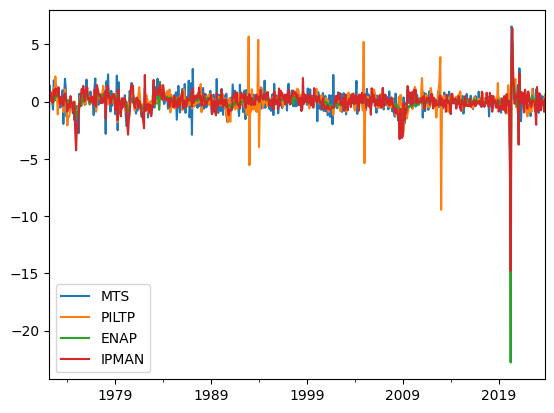

In [273]:
df.plot()
plt.show()

In [274]:
recession = pd.DataFrame(fred.get_series('USRECDM', observation_start=df.index[0], observation_end=df.index[-1]),columns=['USREC'])
recession.head()

,USREC
1972-02-01,0.0
1972-02-02,0.0
1972-02-03,0.0
1972-02-04,0.0
1972-02-05,0.0


# Parameter initialization

Will estimate a dynamic factor model without switching in order to obtain optimal starting parameters. This is important in order to avoid local maxima.


Multivariate models can have a relatively large number of parameters, and it may be difficult to escape from local minima to find the maximized likelihood. In an attempt to mitigate this problem, I perform an initial maximization step (from the model-defined starting parameters) using the modified Powell method available in Scipy (see the minimize documentation for more information). The resulting parameters are then used as starting parameters in the standard LBFGS optimization method.

In [275]:
df_norona = df.loc[df.index<= '2020-02-01']

In [276]:
from statsmodels.tsa.statespace.dynamic_factor import DynamicFactor
dfm_norona = DynamicFactor(
    df_norona, 
                                      k_factors=1, 
                                      factor_order=2, 
                                      error_order=2,
                                      error_var=False,
                                      error_cov_type = 'diagonal',
                                      enforce_stationarity=False
                                      )

dfm = DynamicFactor(
    df, 
                                      k_factors=1, 
                                      factor_order=2, 
                                      error_order=2,
                                      error_var=False,
                                      error_cov_type = 'diagonal',
                                      enforce_stationarity=False
                                      )

# initial_res = dfm.fit(method='powell')
print('NORONA OPTIMIZATION')
initial_res = dfm_norona.fit(maxiter=1000)
print('WILRONA OPTIMIZATION')
res = dfm.fit(start_params=initial_res.params, maxiter=1000)


# res = dfm.fit(start_params=initial_res.params)

NORONA OPTIMIZATION
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.08259D+00    |proj g|=  9.38645D-01


 This problem is unconstrained.



At iterate    5    f=  5.88524D+00    |proj g|=  1.99921D-01

At iterate   10    f=  5.79737D+00    |proj g|=  8.46490D-02

At iterate   15    f=  5.66431D+00    |proj g|=  4.05855D-01

At iterate   20    f=  5.61559D+00    |proj g|=  6.09588D-02

At iterate   25    f=  5.59213D+00    |proj g|=  4.28919D-01

At iterate   30    f=  5.36133D+00    |proj g|=  4.31859D-01

At iterate   35    f=  5.14417D+00    |proj g|=  6.77624D-01

At iterate   40    f=  5.04655D+00    |proj g|=  3.53494D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   45    f=  4.97492D+00    |proj g|=  1.30488D-01

At iterate   50    f=  4.84261D+00    |proj g|=  5.85401D-01



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   55    f=  4.63964D+00    |proj g|=  3.57902D-01

At iterate   60    f=  4.48781D+00    |proj g|=  1.62289D-01
  ys=-1.088E+02  -gs= 1.041E+00 BFGS update SKIPPED



 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.
/Users/williamsoma/miniconda3/envs/jobb/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18     65    167      4     1     0   2.319D+02   3.006D+00
  F =   3.0058427348616936     

ABNORMAL_TERMINATION_IN_LNSRCH                              
WILRONA OPTIMIZATION
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           18     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.17421D+00    |proj g|=  2.15088D+02


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   18      1     21      1     0     0   2.151D+02   3.174D+00
  F =   3.1742055327066185     

ABNORMAL_TERMINATION_IN_LNSRCH                              


/Users/williamsoma/miniconda3/envs/jobb/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "

 Line search cannot locate an adequate point after MAXLS
  function and gradient evaluations.
  Previous x, f and g restored.
 Possible causes: 1 error in function or gradient evaluation;
                  2 rounding error dominate computation.


In [277]:
print(res.summary(separate_params=False))

                                   Statespace Model Results                                  
Dep. Variable:     ['MTS', 'PILTP', 'ENAP', 'IPMAN']   No. Observations:                  622
Model:             DynamicFactor(factors=1, order=2)   Log Likelihood               -1974.356
                                      + AR(2) errors   AIC                           3984.712
Date:                               Sat, 24 Feb 2024   BIC                           4064.505
Time:                                       13:50:09   HQIC                          4015.723
Sample:                                   02-01-1972                                         
                                        - 11-01-2023                                         
Covariance Type:                                 opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

/Users/williamsoma/miniconda3/envs/jobb/lib/python3.11/site-packages/statsmodels/tsa/stattools.py:1420: RuntimeWarning: invalid value encountered in divide
  test_statistic = numer_squared_sum / denom_squared_sum


In [278]:
initial_res.params

loading.f1.MTS         -1.333447
loading.f1.PILTP       -0.499280
loading.f1.ENAP        -0.538544
loading.f1.IPMAN       -1.053852
sigma2.MTS              0.709396
sigma2.PILTP            0.945063
sigma2.ENAP             0.008989
sigma2.IPMAN            0.462301
L1.f1.f1                0.289553
L2.f1.f1                0.308038
L1.e(MTS).e(MTS)       -0.075836
L2.e(MTS).e(MTS)        0.212841
L1.e(PILTP).e(PILTP)   -0.709732
L2.e(PILTP).e(PILTP)   -0.655699
L1.e(ENAP).e(ENAP)      0.938691
L2.e(ENAP).e(ENAP)      0.118147
L1.e(IPMAN).e(IPMAN)   -1.179242
L2.e(IPMAN).e(IPMAN)   -0.108489
dtype: float64

In [279]:
initial_params = res.params
print(initial_params)

loading.f1.MTS         -1.333447
loading.f1.PILTP       -0.499280
loading.f1.ENAP        -0.538544
loading.f1.IPMAN       -1.053852
sigma2.MTS              0.709396
sigma2.PILTP            0.945063
sigma2.ENAP             0.008989
sigma2.IPMAN            0.462301
L1.f1.f1                0.289553
L2.f1.f1                0.308038
L1.e(MTS).e(MTS)       -0.075836
L2.e(MTS).e(MTS)        0.212841
L1.e(PILTP).e(PILTP)   -0.709732
L2.e(PILTP).e(PILTP)   -0.655699
L1.e(ENAP).e(ENAP)      0.938691
L2.e(ENAP).e(ENAP)      0.118147
L1.e(IPMAN).e(IPMAN)   -1.179242
L2.e(IPMAN).e(IPMAN)   -0.108489
dtype: float64


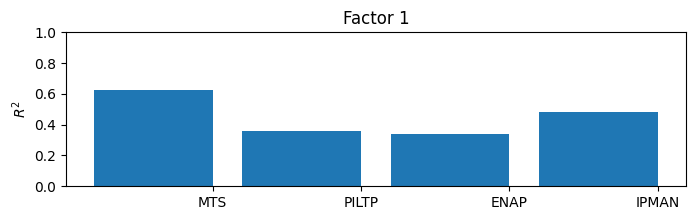

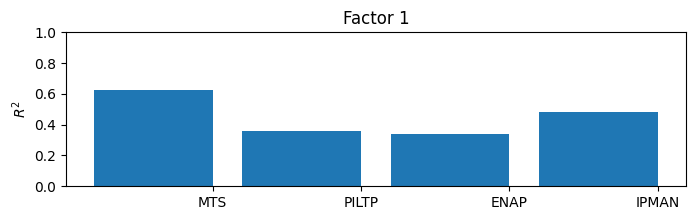

In [289]:
res.plot_coefficients_of_determination(figsize=(8,2))

In [281]:
res.specification

{'k_endog': 4,
 'enforce_stationarity': False,
 'k_factors': 1,
 'factor_order': 2,
 'error_order': 2,
 'error_var': False,
 'error_cov_type': 'diagonal',
 'k_exog': 0}

## Finding inital transition matrix

Will estimate the second equation in our model with exogenous factor.

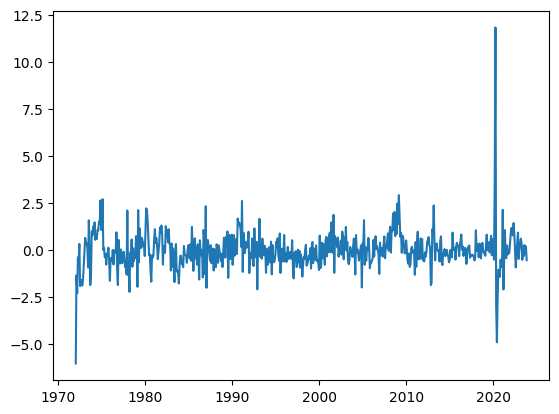

In [284]:
from statsmodels.tsa.regime_switching.markov_autoregression import MarkovAutoregression
smoothed_factor = res.factors['filtered'][0]

smoothed_factor = (smoothed_factor - smoothed_factor.mean()) / smoothed_factor.std()


plt.plot(df.index, smoothed_factor)
plt.show()

In [285]:
# Fit the model
markov = MarkovAutoregression(
    smoothed_factor, k_regimes=2, order=2, switching_ar=False, switching_variance=True, # Switching variance is necessary in order to get anything useful out
)
res_markov = markov.fit(maxiter=1000)

In [286]:
print(res_markov.summary())

                         Markov Switching Model Results                         
Dep. Variable:                        y   No. Observations:                  620
Model:             MarkovAutoregression   Log Likelihood                -713.349
Date:                  Sat, 24 Feb 2024   AIC                           1442.699
Time:                          13:50:12   BIC                           1478.137
Sample:                               0   HQIC                          1456.474
                                  - 620                                         
Covariance Type:                 approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0291      0.056      0.524      0.600      -0.080       0.138
sigma2         0.4510      0.038    

In [287]:
initial_tras_mat = res_markov.regime_transition
initial_tras_mat

array([[[0.9833],
        [0.4305]],

       [[0.0167],
        [0.5695]]])

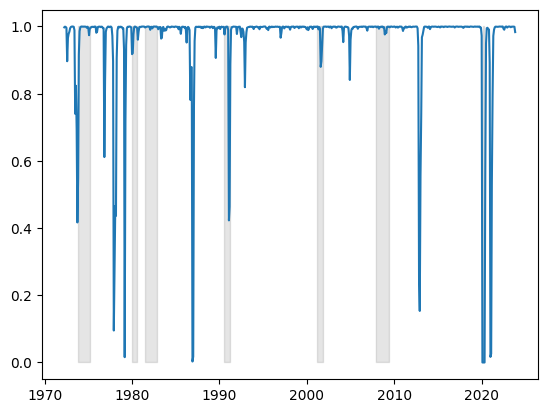

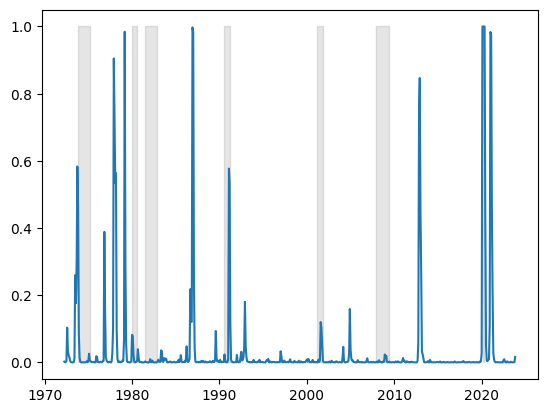

In [288]:
plt.plot(df.index[2:], res_markov.smoothed_marginal_probabilities[:,0])
plt.fill_between(recession.index[2:], 0, 1, where=recession["USREC"].values[2:], color="k", alpha=0.1)
plt.show()
plt.plot(df.index[2:], res_markov.smoothed_marginal_probabilities[:,1])
plt.fill_between(recession.index[2:], 0, 1, where=recession["USREC"].values[2:], color="k", alpha=0.1)
plt.show()

# model estimation

In [293]:
def sigmoid(x):
    '''
    Used to constrain the parameter space between 0 and 1.
    '''
    z = 1/(1 + np.exp(-x)) 
    return z


def Kalman_prediction

In [4]:
np.eye(10)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

In [22]:
import vil_selv.switching_dynamic_factor as sdf

In [23]:
sdf.SwitchingDynamicFactor()

TypeError: SwitchingDynamicFactor.__init__() missing 3 required positional arguments: 'endog', 'k_factors', and 'factor_order'

In [1]:
import vil_selv.hamilton_filter as hf

In [2]:
filetr = hf.HamiltonFilter()

In [ ]:
filetr.